Version info
>v011 - deleted testing codes

>v013 - manipulating multiple beta

>v014 - Handling missing data

Environment

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import pymc3 as pm
import scipy.optimize as so

#import datetime as dt

#from pymc3 import Model, sample, find_MAP, summary
#from pymc3 import NUTS, Metropolis, Slice
#from pymc3 import Normal, Uniform
#from scipy import optimize
#from pymc3 import traceplot

In [5]:
debug = False

In [3]:
debug = True

Loading and preprocessing barley data(explatory variables)

In [6]:
#Loading data file
#barley_raw = pd.read_csv('./data/barley_01.csv', sep=',', header=0, index_col=0)
barley_raw = pd.read_table('./data/barley_01.txt', sep='\t', header=0, index_col=0)

#Explorering data
if debug:
    barley_raw.head()
    barley_raw.info()

#Transposing
barley_t = barley_raw.transpose()
if debug:
    print(barley_t.iloc[0:5, 0:5])

# 39, 96, 116, 103 th DH lines removed for marker mapping(146 marker mappings)
# and also 33 th DH line should be removed for QTL analysis(145 lines)
barley = barley_t.drop(labels=barley_t.index[[39-1, 96-1, 116-1, 103-1, 33-1]])

barley.head()

#Imputed missing(-) to 1 temporarily, I'll use automatic imputation feature of PyMC
#[http://stronginference.com/missing-data-imputation.html]
#barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)
#barley.replace(['A', 'B', '-'], [0,1,-999], inplace=True)
barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)

barley_arr = np.array(barley)

if debug:
    print(barley.ix[:6,10:20])

In [7]:
barley.ix[:2,15:20]

,*ABC310B,*PSR129,*ABC253,*ABG608,*WG380A
1,0,0,1,1,1
2,1,1,1,1,1


In [8]:
barley_arr_masked = np.ma.masked_array(barley_arr, mask=barley_arr==-999)
barley_arr_masked[:5,15:20]
#help(np.ma.masked_array)

masked_array(data =
 [[0 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]],
             mask =
 [[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]],
       fill_value = 999999)

Loading and preprocessing heading data(response variable)

In [9]:
heading_raw = pd.read_table('./data/HED_01.txt', sep='\t', header=0, index_col=0)
heading_raw.replace([-9999.0, -9999], [float('NaN'), float('NaN')], inplace=True)
if debug:
    print(heading_raw.head())
    
# Averaging 'days to heading' over all environments for each line.
heading = heading_raw.mean(skipna=True)
if debug:
    heading.head()



Testing with multivariate beta

In [11]:
num_n = 5 #max 144(total 145 rows)
num_p = 2  #max 126(total 127 columns)
#X = barley.ix[:num_n,:num_p]
Y = heading.ix[:num_n]
X = barley_arr_masked[:num_n,:num_p]


niter = 1000
beta = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



AssertionError: 

Testing of missing value imputation

In [102]:
num_n = 6 #max 144(total 145 rows)
num_p = 2  #max 126(total 127 columns)
Y = np.array([10, 9, 8, 1, 2, 1])
X = np.array([[1,1],[1,0],[1,1],[0,0],[0,1],[-999,0]])
X_masked = np.ma.masked_array(X, mask=X==-999)

ts1 = np.ma.masked_values(X_masked, value=-999)

ts2 = np.ma.masked_values(X_masked[:,1], value=-999)

ts2.shape
ts2

masked_array(data = [1 0 1 0 1 0],
             mask = False,
       fill_value = -999)

In [107]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X_imp[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp_missing


TypeError: unorderable types: int() < NoneType()

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp1_missing
 [-----------------100%-----------------] 1000 of 1000 complete in 0.4 sec04:54:37.871559


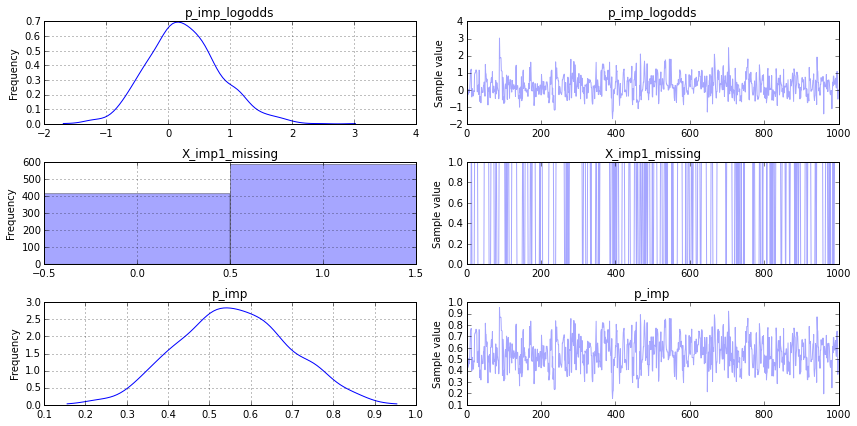

In [97]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)

basic_model = pm.Model()
with basic_model:
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    #for i in range(num_p):
    #    X_imp[i] = pm.Bernoulli('X_imp' + str(i), p_imp, observed=np.ma.masked_values(X_masked[:,i], value=-999))
    #X_imp[0] = pm.Bernoulli('X_imp' + str(0), p_imp, observed=np.ma.masked_values(X_masked[:,0], value=-999))
    X_imp[0] = pm.Bernoulli('X_imp' + str(i), p_imp, observed=np.ma.masked_values(X_masked, value=-999))

        
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())

In [113]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)

basic_model = pm.Model()
with basic_model:
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    X_im = pm.Bernoulli('X_imp' + str(0), p_imp, observed=np.ma.masked_values(X_masked[:,i], value=-999))
        
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp0_missing


TypeError: unorderable types: NoneType() < NoneType()

In [1]:
import pymc3 as pm
import numpy as np

with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=0, upper=100)
    mu = pm.Uniform('mu', lower=0, upper=100)

    data = [34.0, 27.0, 3.0, 17.0, 17.0, 29.0, 53.0]
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=np.asarray(data, dtype='int16'))

    start = pm.find_MAP()

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/NYE/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.3-64/cuda_ndarray/cuda_ndarray.lib and object C:/Users/NYE/AppData/Local/Theano/compiledir_Windows-8-6.2.9200-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.3-64/cuda_ndarray/cuda_ndarray.exp

Using gpu device 0: GeForce GTX 750 (CNMeM is enabled)


TypeError: unorderable types: int() > NoneType()

In [1]:
import pymc3 as pm
import numpy as np

data = [0.0,12.0,12.0,46.0,5.0,11.0,11.0,39.0,4.0,10.0,25.0,11.0,8.0,5.0,10.0,2.0,30.0,21.0]

with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=0.1, upper=100)
    mu = pm.Uniform('mu', lower=0.1, upper=100)

    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)

    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu, 
                                alpha=alpha, 
                                observed=data)

    start = pm.find_MAP()

    step = pm.NUTS()
    trace = pm.sample(2000, step, start=start, progressbar=True)

Using gpu device 0: GeForce GTX 750 (CNMeM is enabled)


ImportError: cannot import name 'futil'

In [6]:
print(pm.__version__)

3.0
